## Agent에 메모리(Memory) 추가

이전 상호작용 context를 기억하는 멀티턴 구현.<br>
LangGraph에서는 persistent checkpointing을 통해 문제 해결.
그래프를 컴파일 할 때 checkpointer를 제공하고 그래프를 호출할 때 thread_id를 제공하면, LangGraph는 각 단계 후 상태를 자동으로 저장.<br>
동일한 thread_id를 사용하여 그래프를 다시 호출하면, 그래프는 저장된 상태를 로드하여 챗봇이 이전에 중단한 지점에서 대화 이어나갈 수 있다.<br><br>

checkpointing은 LangChain의 메모리 기능보다 훨씬 더 강력.

In [1]:
from dotenv import load_dotenv
from langchain_teddynote import logging

load_dotenv()
logging.langsmith("LangGraph-Modules")

LangSmith 추적을 시작합니다.
[프로젝트명]
LangGraph-Modules


In [4]:
from langgraph.checkpoint.memory import MemorySaver

# 메모리 저장소 생성
memory = MemorySaver()


**in-memory checkpointer** 사용.
- 프로덕션 단계에서는 SqliteSaver 또는 PostgreSaver로 변경하고 자체 DB에 연결할 수 있다.

In [5]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langchain_teddynote.tools.tavily import TavilySearch
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

# 상태 정의
class State(TypedDict):
    messages: Annotated[list, add_messages]

# 도구 초기화
tool = TavilySearch()
tools = [tool]

# llm 초기화
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# 도구와 llm 연결
llm_with_tools = llm.bind_tools(tools)

# 챗봇 정의 함수
def chatbot(state: State):
    return {'messages' : [llm_with_tools.invoke(state['messages'])]}

# 상태 그래프 생성
graph_builder = StateGraph(State)

# 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)

# 도구 노드 생성 및 추가
tool_node = ToolNode(tools)

# 도구 노드 추가
graph_builder.add_node("tools", tool_node)

# 조건부 엣지
graph_builder.add_conditional_edges(
    "chatbot",
    # 1. State에서 마지막 메시지 추출
    # 2. 도구 호출 여부 확인
    # 도구 호출이 있으면 "tools" 노드로
    # 없으면 종료
    tools_condition
)


# 엣지 추가
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# 그래프 컴파일
graph = graph_builder.compile(checkpointer=memory)

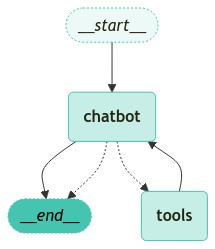

In [6]:
from langchain_teddynote.graphs import visualize_graph

# 그래프 시각화
visualize_graph(graph)

## RunnableConfig 설정

RunnaableConfig 정의하고 recursion_limit과 thread_id 설정.
- recursion_limit : 최대 방문할 노드 수. 그 이상은 RecursionError 발생.
- thread_id : 그래프 실행 시 사용할 고유 식별자.

thread_id는 대화 세션을 구분하는데 사용. 즉, 메모리의 저장은 thread_id에 따라 개별적으로 이루어짐.

In [7]:
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    recursion_limit=10,
    configurable={"thread_id": "1"}
)

In [9]:
question = (
    "내 이름은 '테디노트' 입니다. Youtube 채널을 운영하고 있어요. 만나서 반가워요"
)

for event in graph.stream({"messages": [("user", question)]}, config = config):
    for value in event.values():
        value['messages'][-1].pretty_print()

================================== Ai Message ==================================

안녕하세요, 테디노트님! 만나서 반갑습니다. 유튜브 채널을 운영하고 계시다니 멋지네요! 어떤 주제로 채널을 운영하고 계신가요? 도움이 필요하시면 언제든지 말씀해 주세요.


In [10]:
question = (
    "내 이름이 뭐라고 했지?"
)

for event in graph.stream({"messages": [("user", question)]}, config = config):
    for value in event.values():
        value['messages'][-1].pretty_print()

================================== Ai Message ==================================

당신의 이름은 '테디노트'입니다.


In [11]:
from langchain_core.runnables import RunnableConfig

question = "내 이름이 뭐라고 했지?"

config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "2"},  # 스레드 ID 설정
)

for event in graph.stream({"messages": [("user", question)]}, config=config):
    for value in event.values():
        value["messages"][-1].pretty_print()

================================== Ai Message ==================================

죄송하지만, 당신의 이름을 알 수 있는 정보가 없습니다. 이름을 알려주시면 그에 맞춰 대화할 수 있습니다!


In [12]:
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    configurable={"thread_id": "1"},  # 스레드 ID 설정
)
# 그래프 상태 스냅샷 생성
snapshot = graph.get_state(config)
snapshot.values["messages"]

[HumanMessage(content="내 이름은 '테디노트' 입니다. Youtube 채널을 운영하고 있어요. 만나서 반가워요", additional_kwargs={}, response_metadata={}, id='e10e20c7-ae50-4da4-a82f-26602e11571d'),
 AIMessage(content='안녕하세요, 테디노트님! 만나서 반갑습니다. 유튜브 채널을 운영하고 계시다니 멋지네요! 어떤 주제로 채널을 운영하고 계신가요? 도움이 필요하시면 언제든지 말씀해 주세요.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 117, 'total_tokens': 174, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'stop', 'logprobs': None}, id='run-2ff52bb2-31aa-48a8-9963-c24cc6127edc-0', usage_metadata={'input_tokens': 117, 'output_tokens': 57, 'total_tokens': 174, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
 HumanMessage(

In [13]:
# 설정된 config 정보
snapshot.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa0c5e-e045-6f74-8004-b6cc90d5446e'}}

In [14]:
# 저장된 값(values)
snapshot.values

{'messages': [HumanMessage(content="내 이름은 '테디노트' 입니다. Youtube 채널을 운영하고 있어요. 만나서 반가워요", additional_kwargs={}, response_metadata={}, id='e10e20c7-ae50-4da4-a82f-26602e11571d'),
  AIMessage(content='안녕하세요, 테디노트님! 만나서 반갑습니다. 유튜브 채널을 운영하고 계시다니 멋지네요! 어떤 주제로 채널을 운영하고 계신가요? 도움이 필요하시면 언제든지 말씀해 주세요.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 117, 'total_tokens': 174, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'stop', 'logprobs': None}, id='run-2ff52bb2-31aa-48a8-9963-c24cc6127edc-0', usage_metadata={'input_tokens': 117, 'output_tokens': 57, 'total_tokens': 174, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),


In [15]:
# 다음 노드
snapshot.next

()

In [16]:
snapshot.metadata["writes"]["chatbot"]["messages"][0]

AIMessage(content="당신의 이름은 '테디노트'입니다.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 189, 'total_tokens': 203, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'stop', 'logprobs': None}, id='run-2f0f7864-367a-4ef1-8a25-0c62af1bafca-0', usage_metadata={'input_tokens': 189, 'output_tokens': 14, 'total_tokens': 203, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [17]:
from langchain_teddynote.messages import display_message_tree

# 메타데이터(tree 형태로 출력)
display_message_tree(snapshot.metadata)

    source: "loop"
    writes:
        chatbot:
            messages:
                index [0]
                    content: "당신의 이름은 '테디노트'입니다."
                    additional_kwargs: {"refusal": None}
                    response_metadata:
                        token_usage:
                            completion_tokens: 14
                            prompt_tokens: 189
                            total_tokens: 203
                            completion_tokens_details: {"audio_tokens": 0, "reasoning_tokens": 0, "accepted_prediction_tokens": 0, "rejected_prediction_tokens": 0}
                            prompt_tokens_details: {"audio_tokens": 0, "cached_tokens": 0}
                        model_name: "gpt-4o-mini-2024-07-18"
                        system_fingerprint: "fp_0ba0d124f1"
                        finish_reason: "stop"
                        logprobs: None
                    type: "ai"
                    name: None
                    id: "run-2f0f7864-367a-4ef1-8a25-0c